<a href="https://colab.research.google.com/github/aryan-at-ul/group_project_waves_predictions/blob/main/wave_related_notebooks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install -U -q PyDrive

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = "https://drive.google.com/file/d/1-xJ06pAoGX6bo3b9wK9FCsONluI9MpBW/view?usp=sharing"
idd = link.split("/")[-2]
print(idd)
downloaded = drive.CreateFile({'id':idd})
print(downloaded)
downloaded.GetContentFile('bouy_data_hourly_mean.csv')

1-xJ06pAoGX6bo3b9wK9FCsONluI9MpBW
GoogleDriveFile({'id': '1-xJ06pAoGX6bo3b9wK9FCsONluI9MpBW'})


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

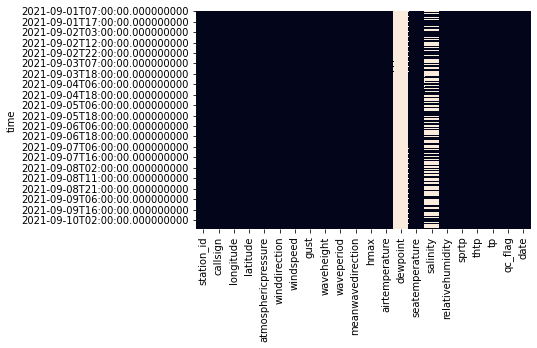

In [ ]:
df = pd.read_csv("bouy_data_hourly_mean.csv",parse_dates=["time"],index_col=["time"])
df.head()
sns.heatmap(df[-1000:].isnull(), cbar=False)

In [ ]:
station_names_set = set(df["station_id"])
size = df.shape[0]

# for station in station_names_set:
#     mask = df["station_id"].values == station
#     size = df.shape[0]
#     station_obs_size = mask.sum()
#     sns_plot = sns.heatmap(df[mask].isnull(), cbar=False)
#     sns_plot.figure.savefig(f"/content/output/null_spread_at_{station}_{station_obs_size}_{size}.png")

# next stuff done on m5 data as it has minimun null values 

In [ ]:
df.shape

(748045, 22)

In [ ]:
for station in station_names_set:
    mask = df["station_id"].values == station
    station_obs_size = mask.sum()
    print(f"null values at station : {station} , with total observation of {station_obs_size}")
    print(df[mask].isnull().sum(axis=0))
    print("===================================")

In [ ]:
for station in station_names_set:
    mask = df["station_id"].values == station
    station_obs_size = mask.sum()
    df_st_series = df[mask].isnull().sum(axis=0)
    print(f"null values at station : {station} ,with observation of {station_obs_size} out of {size}")
    # print(df[mask].isnull().sum(axis=0))
    df_st_series.plot(kind='bar',title = f"null per cols for station {station}")
    plt.show()

below we try to impute missing values using cubic method, and then plot them, those fit looks logical

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Index(['atmosphericpressure', 'winddirection', 'windspeed', 'gust',
       'waveheight', 'waveperiod', 'meanwavedirection', 'hmax',
       'airtemperature', 'dewpoint', 'seatemperature', 'salinity',
       'relativehumidity'],
      dtype='object')
(131326, 13)
plotting for col:atmosphericpressure


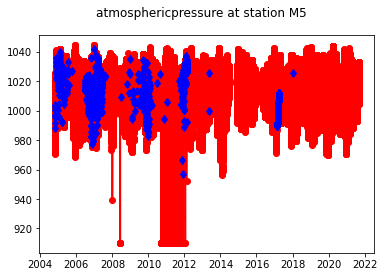

plotting for col:winddirection


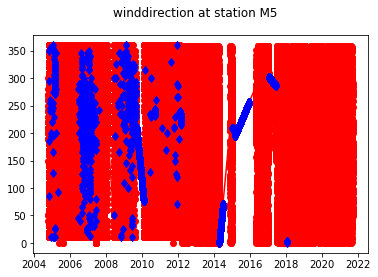

plotting for col:windspeed


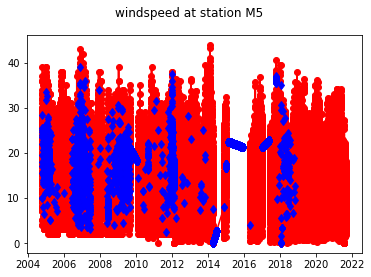

plotting for col:gust


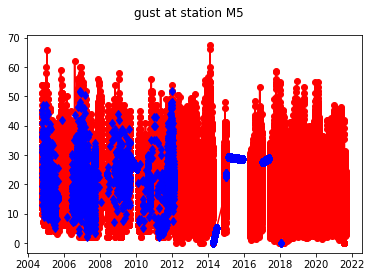

plotting for col:waveheight


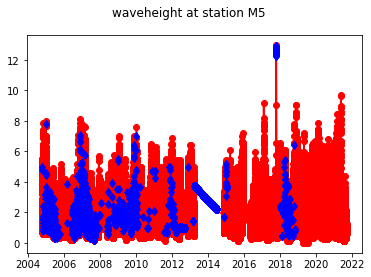

plotting for col:waveperiod


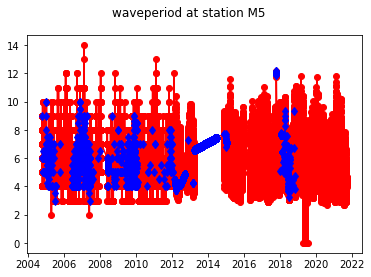

plotting for col:meanwavedirection


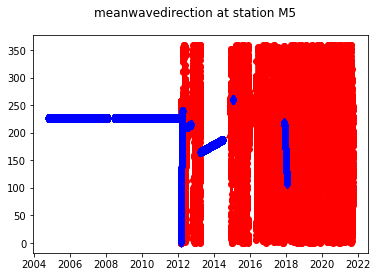

plotting for col:hmax


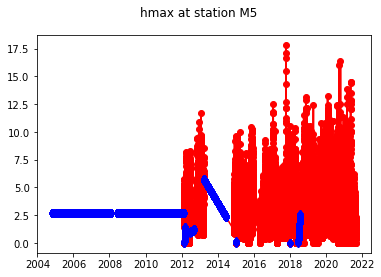

plotting for col:airtemperature


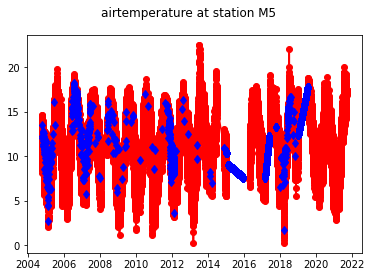

plotting for col:dewpoint


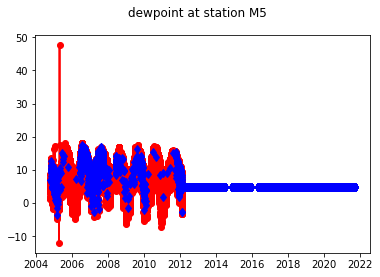

plotting for col:seatemperature


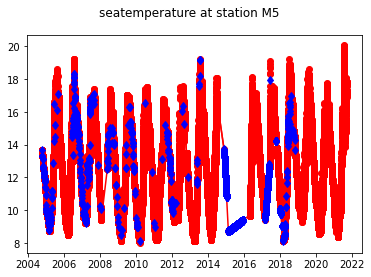

plotting for col:salinity


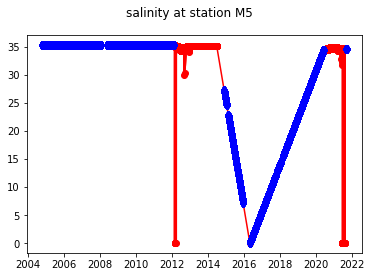

plotting for col:relativehumidity


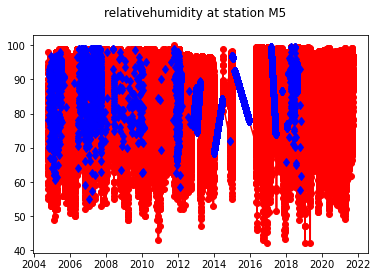

In [ ]:
#pd.options.mode.chained_assignment = None
#mask = df["station_id"].values == "M5"  # could get wrong but this is fast
mask = df.loc[df.station_id == "M5" ]
df_m5 = mask#df[mask]
df_m5.drop(['date','station_id','callsign','longitude','latitude','qc_flag','tp','qc_flag','thtp','sprtp'],axis = 1, inplace=True)
print(df_m5.columns)
#df_m5 = df_m5[0:1500]
print(df_m5.shape)
null_mask = df_m5.isnull()
df_m5 = df_m5.interpolate(method="time",axis = 0).ffill().bfill()
imputed = df_m5[null_mask]
not_imputed = df_m5[~null_mask]
# ignore_cols = ['station_id','callsign','longitude','latitude','qc_flag','tp','qc_flag','thtp']
for c in df_m5.columns:
#     if c in ignore_cols:
#         continue
    print(f"plotting for col:{c}")
    plt.suptitle(f'{c} at station M5')
    plt.plot(df_m5[c],color = 'r')
    plt.plot(not_imputed[c],color = 'r', marker = 'o')
    plt.plot(imputed[c],linestyle = '',color = 'b',marker = 'd')
    #plt.savefig(f'/content/plots/station_M5_{c}_imputation_results_small_range.png')
    plt.show()
    print("===============================")

In [ ]:
#saving imputed csv file station wise
for station in station_names_set:
    mask = df.loc[df.station_id == station ]
    df_m5 = mask#df[mask]
    df_m5.drop(['date'],axis = 1, inplace=True)
    null_mask = df_m5.isnull()
    df_m5 = df_m5.interpolate(method="time",axis = 0).ffill().bfill()
    df_m5.to_csv(f"{station}_interpolated_data.csv",index=False)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
from IPython.display import Math,display,HTML
import math

In [ ]:
display(HTML("""<a href = "https://en.wikipedia.org/wiki/Wave_power">wave power wiki</a>"""))
display(Math("\\text{Wave power formula = } \\frac{\\rho g^2}{64 \\pi}{H_{m0}^2 T_{e}}"))

<IPython.core.display.Math object>

assuming wave height = waveheight in csv , wave period is wave period in csv , density is $$\rho = 1000kg/m^3$$ and Te being wave period 

##Not sure about units in csv file

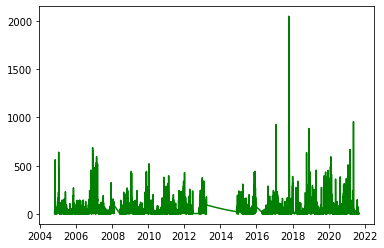

In [ ]:
# adding a col that represents power at a point
def power_at_a_time(row):
    density = 1000.0
    gravity = 9.8 
    const = (density * gravity ** 2) / (64.0 * math.pi)
    power = (row['waveheight'] ** 2 ) * row['waveperiod']
    return power
#formula from wifipedia
df_m5['power'] = df_m5.apply(lambda row: power_at_a_time(row),axis = 1)
df_m5.head()
plt.plot(df_m5['power'],color = 'g')
plt.show()


In [ ]:
df_m5.describe().T.style.bar(subset=['mean'],color='#205ef2').background_gradient(subset=['std'],cmap='Greens').background_gradient(subset=['50%'],cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
atmosphericpressure,131326.000000,1014.631455,12.166236,910.200000,1007.400000,1016.000000,1023.000000,1044.400000
winddirection,131326.000000,203.490791,91.397644,0.000000,147.000000,220.000000,269.000000,360.000000
windspeed,131326.000000,15.185940,6.593880,0.000000,10.132000,15.000000,20.493000,43.831000
gust,131326.000000,20.576052,8.794034,0.000000,14.000000,20.037000,27.505604,67.455000
waveheight,131326.000000,1.891397,1.093953,0.000000,1.094000,1.641000,2.500000,12.969000
waveperiod,131326.000000,5.576594,1.298371,0.000000,4.570000,5.273000,6.630213,14.000000
meanwavedirection,131326.000000,214.069385,50.076508,0.000000,215.000000,226.000000,226.000000,359.000000
hmax,131326.000000,2.779448,1.273875,0.000000,2.344000,2.734000,2.734000,17.813000
airtemperature,131326.000000,11.681282,3.237960,0.229000,9.048000,11.475000,14.551000,22.480000
dewpoint,131326.000000,6.632396,3.401253,-12.100000,4.900000,4.900000,8.400000,47.600000


(131326, 14)

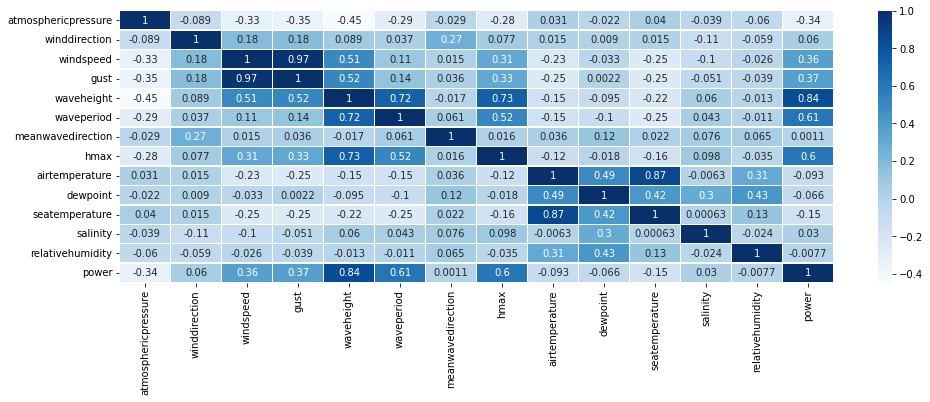

In [ ]:
# some cols dont seem to have any kind of impact on power , so many in case of a multivariate model ,
# we need tp predict height and wave freq (freq can depend on wind speed etc)
corr = df_m5.corr()
plt.figure(figsize=(16,5))
sns.heatmap(corr,cmap= 'Blues',annot=True,linewidths=.5)
# useless !!!!
df_m5.shape

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


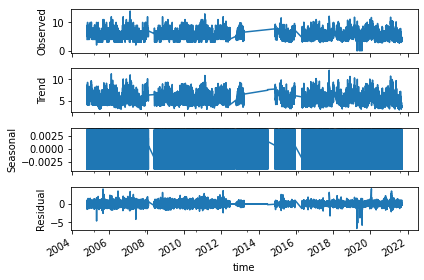

In [ ]:
#analysis = df_m5[['waveheight']].copy()
decompose_result_mult = seasonal_decompose(df_m5['waveperiod'], model="additive",freq=10)
trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid
decompose_result_mult.plot();

In [ ]:
#monthly min max  # to do more on season trends etc 
# plt.figure(figsize=(10,7))
# timestep = df_m5.index.to_numpy()
# #print(timestep)
# res = df_m5.resample(rule='M').mean()
# print(res)
# timestep = res.index.to_numpy()
# vals = res['waveheight'].to_numpy()
# print(vals)

#plot_time_series(timestep,vals)
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
df_m5.shape
df_m5.columns
df_m5_copy = df_m5.copy()
df_m5_copy = df_m5_copy.resample('M').mean()
df_m5_copy = df_m5_copy.interpolate(method="time",axis = 0).ffill().bfill()
df_m5_copy.index = pd.DatetimeIndex(df_m5_copy.index).to_period('M')
train_data = df_m5_copy.iloc[:int(0.8 * len(df_m5_copy.index))-1]
test_data = df_m5_copy.iloc[int(0.8 * len(df_m5_copy.index)):]

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimes.py:1092: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


In [ ]:
model_1 = exp_smooth = ExponentialSmoothing(endog=train_data['waveheight'], 
                                  damped=True, 
                                  dates=None,
                                  freq=None,                                  
                                  missing='none', 
                                  seasonal='mul', 
                                  seasonal_periods=12, 
                                  trend='mul')
model_1_fitted = model_1.fit()

In [ ]:
model_1_fitted = ExponentialSmoothing(train_data['waveheight'],trend = 'mul', seasonal='mul' , seasonal_periods = 12).fit()

In [ ]:
test_predictions = model_1_fitted.forecast(40) 

In [ ]:
test_predictions

2018-05    1.862155
Freq: M, dtype: float64

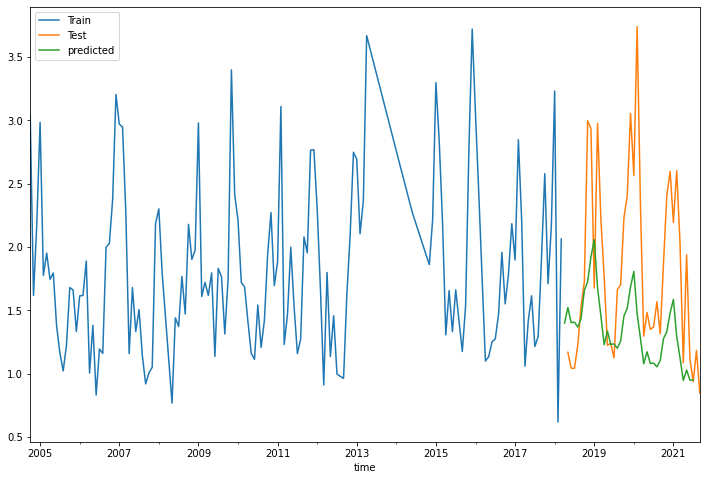

In [ ]:
train_data['waveheight'].plot(legend=True,label='Train',figsize = (12,8))
test_data['waveheight'].plot(legend=True,label='Test')
test_predictions.plot(legend=True,label = 'predicted')

# below here we are trying to replicate some know models and evaluate predictions using error functions and some plots 


In [ ]:
import os 
import sys
import tensorflow as tf

In [ ]:
def mean_absolute_scaled_error(y_true, y_pred):
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # implement for season if one knows the season
  return mae / mae_naive_no_season

In [ ]:
def evaluate_preds(y_true, y_pred):
    #all values should be as small as possible
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)
  
    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy()}

In [ ]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None,figname = None):

    # Plot the series do not pass df 
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("time")
    plt.ylabel("y values")
    if label:
        plt.legend(fontsize=14) # make label bigger
    if figname:
        plt.savefig(f'{figname}.png')
    plt.grid(True)

In [ ]:
# creating train and test split
timesteps = df_m5.index.to_numpy()
waveperiod = df_m5["waveperiod"].to_numpy()
timesteps[:10], waveperiod[:10]

(array([Timestamp('2004-10-18 10:00:00+0000', tz='UTC'),
        Timestamp('2004-10-18 11:00:00+0000', tz='UTC'),
        Timestamp('2004-10-18 12:00:00+0000', tz='UTC'),
        Timestamp('2004-10-18 13:00:00+0000', tz='UTC'),
        Timestamp('2004-10-18 14:00:00+0000', tz='UTC'),
        Timestamp('2004-10-18 15:00:00+0000', tz='UTC'),
        Timestamp('2004-10-18 17:00:00+0000', tz='UTC'),
        Timestamp('2004-10-18 18:00:00+0000', tz='UTC'),
        Timestamp('2004-10-18 19:00:00+0000', tz='UTC'),
        Timestamp('2004-10-18 20:00:00+0000', tz='UTC')], dtype=object),
 array([4., 5., 5., 5., 5., 4., 4., 4., 4., 4.]))

In [ ]:
split_size = int(0.8 * len(waveperiod))

In [ ]:
X_train, y_train = timesteps[:split_size], waveperiod[:split_size]
X_test, y_test = timesteps[split_size:], waveperiod[split_size:]
len(X_train), len(X_test), len(y_train), len(y_test)

(105060, 26266, 105060, 26266)

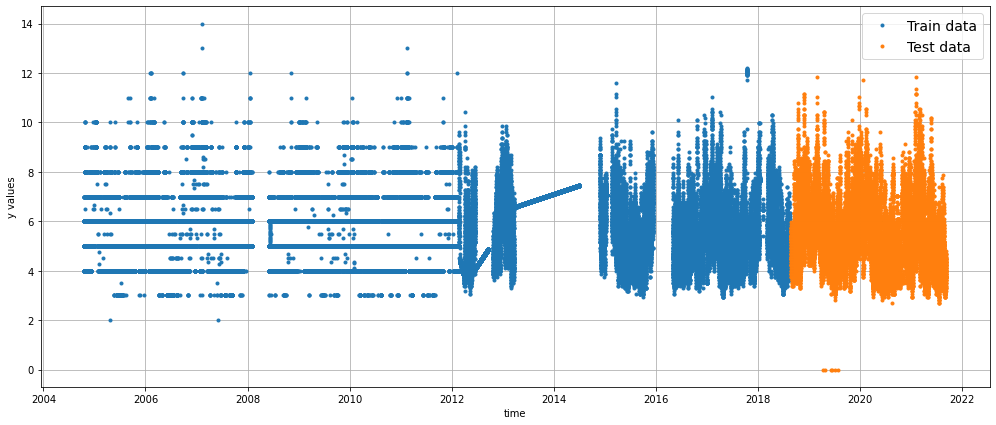

In [ ]:
#plotting train test set but fig would be ugly 
# plt.figure(figsize=(17, 10))
# plt.scatter(X_train, y_train, s=2, label="Train data")
# plt.scatter(X_test, y_test, s=2, label="Test data")
# plt.xlabel("Date")
# plt.ylabel("waveperiod")
# plt.legend(fontsize=14)
# plt.show();
plt.figure(figsize=(17, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data",figname = 'train_and_test_split')


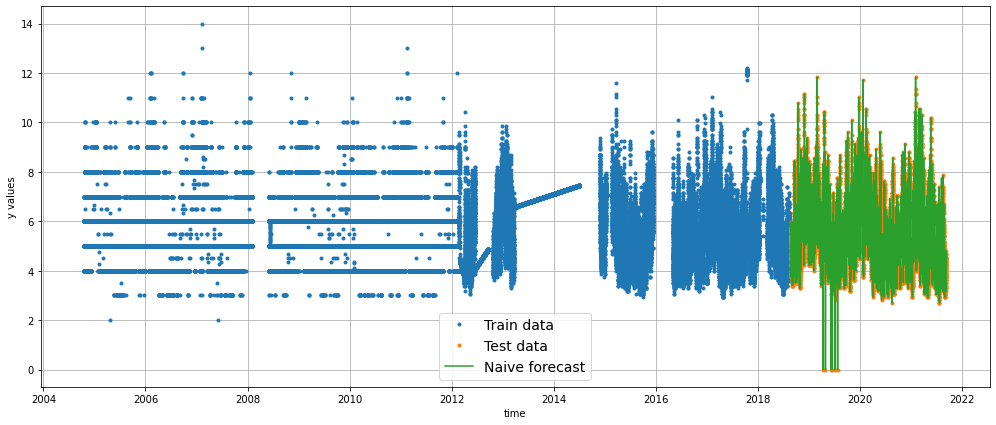

In [ ]:
# testing shifiting , like value at t = value at t - 1  
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:]

plt.figure(figsize=(17, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast",figname="prediction_naive");

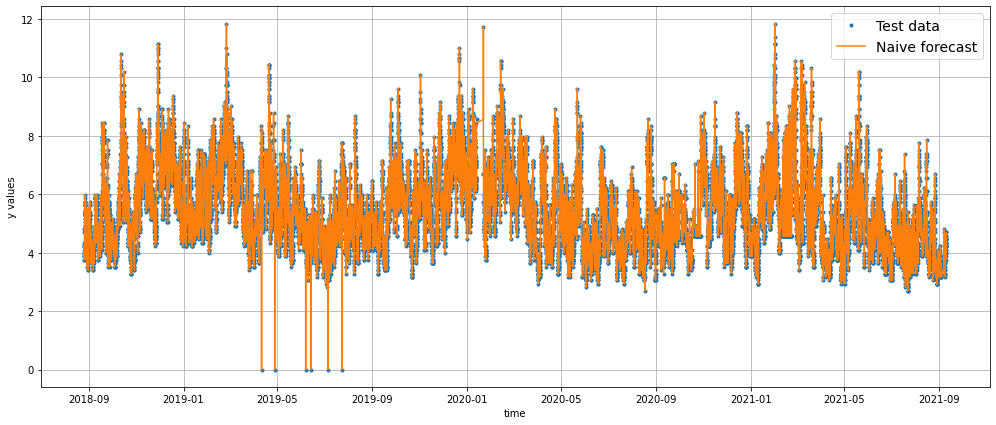

In [ ]:
# there is some issue with data need to check it manually , lets try some other plots
plt.figure(figsize=(17, 7))
offset = 0
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast",figname='naive_fore_cast');

In [ ]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 0.20697123,
 'mape': 1146662.6,
 'mase': 0.999962,
 'mse': 0.12874742,
 'rmse': 0.3588139}

In [ ]:
HORIZON = 1  # how far in the future 
WINDOW_SIZE = 7 # how far in the past // lets do for 1 day at a time , there are methods to calculate confidence interval and stuff

In [ ]:
def get_labelled_windows(x, horizon=1):
    #splitting data into two , past and future 
    return x[:, :-horizon], x[:, -horizon:]

In [ ]:
def make_windows(x, window_size=7, horizon=1):
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
    windowed_array = x[window_indexes]
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return windows, labels

In [ ]:
#test 
full_windows, full_labels = make_windows(waveperiod, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)
for i in range(3):
    print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [4. 5. 5. 5. 5. 4. 4.] -> Label: [4.]
Window: [5. 5. 5. 5. 4. 4. 4.] -> Label: [4.]
Window: [5. 5. 5. 4. 4. 4. 4.] -> Label: [4.]


In [ ]:
def make_train_test_splits(windows, labels, test_split=0.2):
    split_size = int(len(windows) * (1-test_split)) 
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)


np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

In [ ]:
def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), 
                                                verbose=0,
                                                save_best_only=True)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear")                         
], name="model_1_dense") # model name 1 

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) 

# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of waveperiod 1-7 days and then 7th day the target 
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day) a bit like naive 
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
821/821 [==============================] - 2s 2ms/step - loss: 0.2721 - mae: 0.2721 - val_loss: 0.2165 - val_mae: 0.2165
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
Epoch 2/100
821/821 [==============================] - 2s 2ms/step - loss: 0.2228 - mae: 0.2228 - val_loss: 0.2131 - val_mae: 0.2131
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
Epoch 3/100
821/821 [==============================] - 2s 2ms/step - loss: 0.2213 - mae: 0.2213 - val_loss: 0.2114 - val_mae: 0.2114
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
Epoch 4/100
821/821 [==============================] - 1s 2ms/step - loss: 0.2200 - mae: 0.2200 - val_loss: 0.2110 - val_mae: 0.2110
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
Epoch 5/100
821/821 [==============================] - 1s 2ms/step - loss: 0.2180 - mae: 0.2180 - val_loss: 0.2310 - val_mae: 0.2310
Epoch 6/100
821/821 [==================

In [ ]:
model_1.evaluate(test_windows, test_labels)
print(test_windows,"======================",test_labels)
#model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
#model_1.evaluate(test_windows, test_labels)

821/821 [==============================] - 1s 1ms/step - loss: 0.2078 - mae: 0.2078
[[4.453 4.453 4.336 ... 3.867 4.219 4.219]
 [4.453 4.336 4.219 ... 4.219 4.219 4.102]
 [4.336 4.219 3.867 ... 4.219 4.102 3.984]
 ...
 [4.336 4.688 4.688 ... 4.453 4.453 4.453]
 [4.688 4.688 4.57  ... 4.453 4.453 4.219]
 [4.688 4.57  4.453 ... 4.453 4.219 4.336]] ====================== [[4.102]
 [3.984]
 [3.867]
 ...
 [4.219]
 [4.336]
 [4.219]]


In [ ]:
# caution !!!!!
def make_preds(model, input_data):
    #print(input_data[0])
    forecast = model.predict(input_data)
    print(forecast)
    return tf.squeeze(forecast)

In [ ]:
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

[[4.2120237]
 [4.098792 ]
 [3.9804022]
 ...
 [4.4451284]
 [4.216608 ]
 [4.3289337]]


(26264, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([4.2120237, 4.098792 , 3.9804022, 3.863525 , 3.860401 , 3.7465706,
        3.7455204, 3.8600242, 3.981051 , 4.2206993], dtype=float32)>)

In [ ]:
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 0.20778018,
 'mape': 1146158.0,
 'mase': 1.0038537,
 'mse': 0.124268435,
 'rmse': 0.35251728}

26264 [4.102 3.984 3.867 ... 4.219 4.336 4.219]


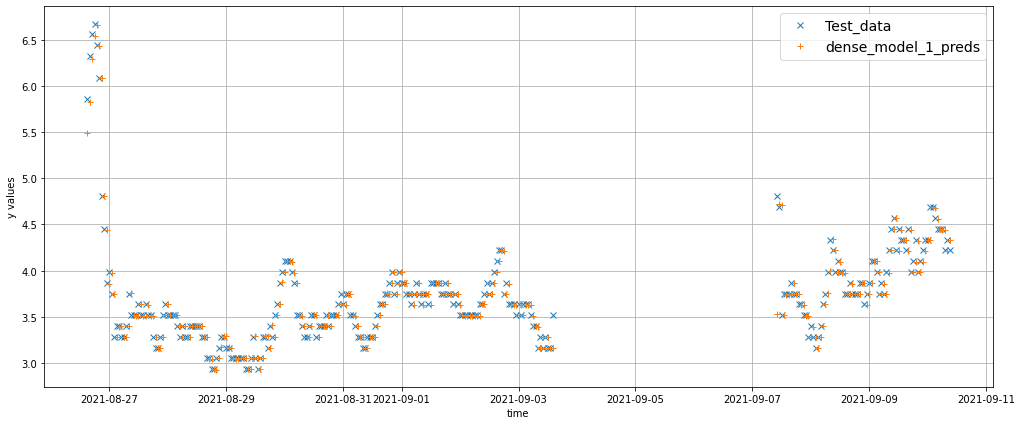

In [ ]:
offset = 26000
plt.figure(figsize=(17, 7))
#  test again for correct window
print(len(test_windows),test_labels[:,0])
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset,format="x", label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="+", label="dense_model_1_preds",figname='dense_model_prediciton_most_recent')